In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import datetime
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

# Алгоритм иерархической кластеризации

In [12]:
# иерархическая кластеризация
def hier(cluster_):
    clusters = [cluster_]
    distances = dict()
    list_indexes_1 = []
    list_indexes_2 = []
    list_dists = []
    list_lens = []

    for i in range(1, len(cluster_) + 1):
        min_dist = 10 ** 9
        if len(clusters[-1]) == 1:
            max_ = 0
            for _ in range(len(list_dists)):
                if _ != len(list_dists) - 1:
                    if abs(list_dists[_ + 1] - list_dists[_]) > max_:
                        max_ = abs(list_dists[_ + 1] - list_dists[_])
                        index_ = _

            matrix = np.array([list_indexes_1, list_indexes_2, list_dists, list_lens])
            return clusters[index_], matrix, len(clusters[index_])
        
        if i == 1:
            for k in range(len(clusters[i - 1])):
                for j in range(len(clusters[i - 1])):
                    if k != j:
                        dist = np.linalg.norm(np.array(clusters[i - 1][k]) - np.array(clusters[i - 1][j]))
                        distances[(clusters[i - 1][k], clusters[i - 1][j])] = dist

                        if dist < min_dist:
                            min_dist = dist
                            min_1 = clusters[i - 1][k]
                            min_2 = clusters[i - 1][j]
        else:
            for key, value in distances.items():
                if value < min_dist:
                    min_dist = value
                    min_1 = key[0]
                    min_2 = key[1]
        if i == 1:
            clust_for_indexes = clusters[-1]
        else:
            clust_for_indexes.append(new_cluster)

        new_cluster = (min_1, min_2)
        
        index_1 = clust_for_indexes.index(min_1)
        index_2 = clust_for_indexes.index(min_2)
        dist_ = min_dist
        len_1 = len(post_process(min_1))
        len_2 = len(post_process(min_2))
        total_len = len_1 + len_2

        list_indexes_1.append(index_1)
        list_indexes_2.append(index_2)
        list_dists.append(dist_)
        list_lens.append(total_len)

        cluster_copy = clusters[-1].copy()
        cluster_copy.remove(min_1)
        cluster_copy.remove(min_2)
        clusters.append([*cluster_copy])

        for s in clusters[-1]:
            v_s = distances.get((s, new_cluster[0]))
            if v_s is None:
                v_s = distances.get((new_cluster[0], s))

            u_s = distances.get((s, new_cluster[1]))
            if u_s is None:
                u_s = distances.get((new_cluster[1], s))

            distances[(new_cluster, s)] = 0.5 * (v_s + u_s + abs(v_s - u_s))

        keys_ = []
        for key_ in distances.keys():
            if min_2 in key_ or min_1 in key_:
                keys_.append(key_)

        for k_ in keys_:
            del distances[k_]

        clusters[-1].append(new_cluster)

# постобработка выхода иерархической кластеризации
def post_process(cl):
    i = 0
    list_ = []
    for symb in str(cl):
        if symb == '(' and str(cl)[i+1] in ['1', '2', '3', '4', '5', '6', '7', '8', '9']:
            list_.append(str(cl)[i-1: str(cl)[i-1:].find(')')+i].replace('(', '').replace(')', ''))
        else:
            pass
        i += 1
    return list_
                               
def create_str(list_1):
    str_to_df = []
    for i_ in list_1:
        str_to_df_ = []
        for j_ in i_.split(','):
            str_to_df_.append(float(j_))   
        str_to_df.append(str_to_df_)
    return str_to_df

# Метрики кластеризации

In [10]:
# среднее внутрикластерное расстояние
def inner_clus(clusters, list_num):
    list_dist = []
    for i in list_num:
        cluster = clusters[clusters['flag'] == i]
        sum_ = 0
        for idx, row in cluster.iterrows():
            for jdx, row_ in cluster.iterrows():
                if idx < jdx:
                    sum_ += np.linalg.norm(np.array(list(row)) - np.array(list(row_)))
        list_dist.append(sum_ / len(cluster))
    
    return sum(list_dist)

In [11]:
# среднее межкластерное расстояние
def outer_clus(clusters, list_num):
    list_dist = []
    for i in list_num:
        cluster = clusters[clusters['flag'] == i]
        sum_ = 0
        for idx, row in cluster.iterrows():
            for jdx, row_ in clusters[clusters['flag'] != i].iterrows():
                sum_ += np.linalg.norm(np.array(list(row)) - np.array(list(row_)))
        
        list_dist.append(sum_ / len(cluster))
    
    return sum(list_dist)

# Загрукза и визуализация данных

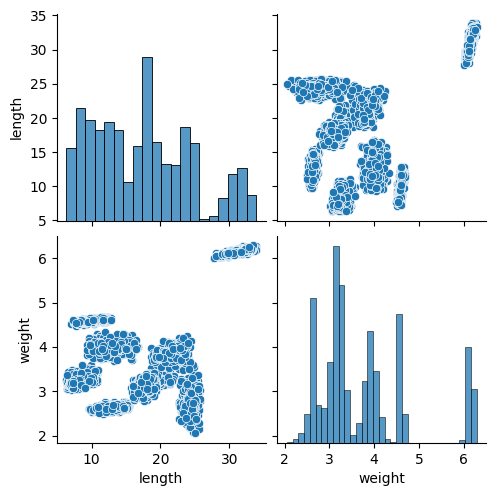

In [4]:
data_fish = pd.read_csv("fish_data.csv")
data_fish = data_fish.drop(['w_l_ratio'], axis=1)
sns.pairplot(data_fish)

In [5]:
X_fish = data_fish.drop(['species'], axis=1)
y_fish = data_fish['species']

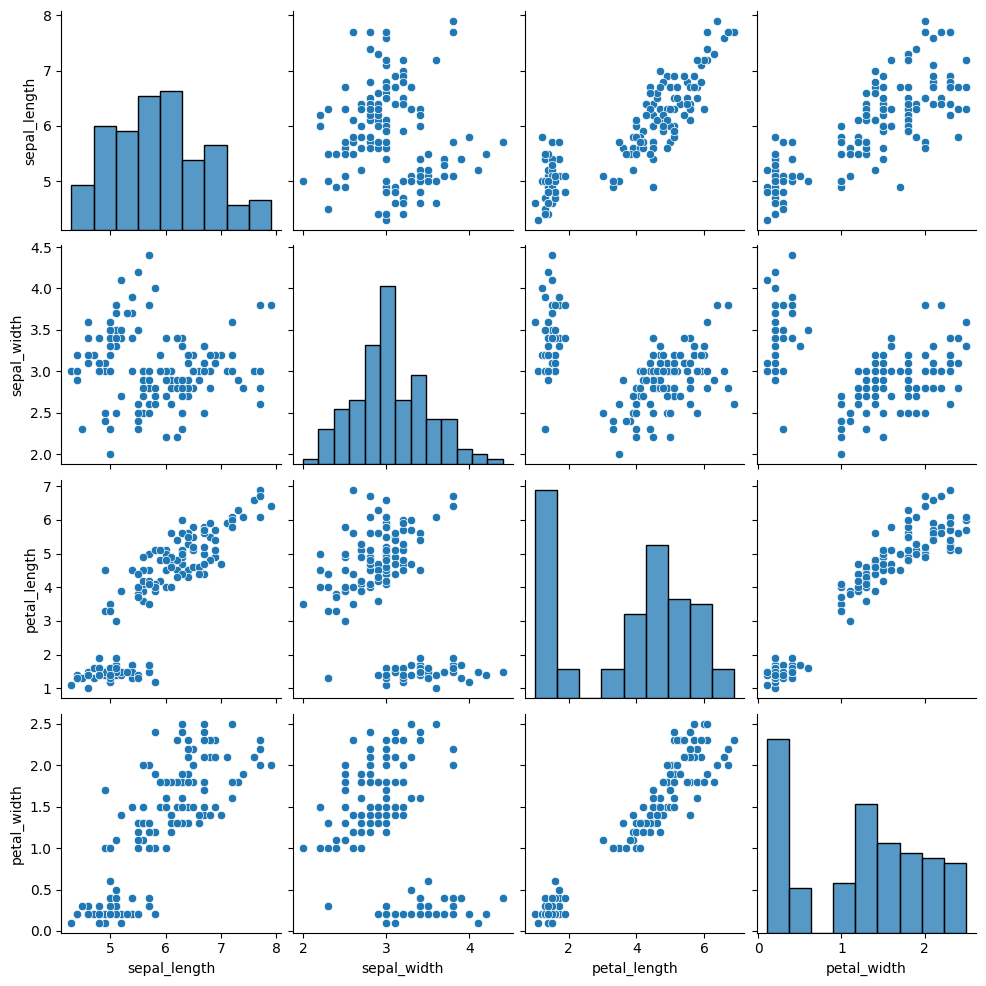

In [6]:
data_iris = pd.read_csv("iris.csv")
data_iris = data_iris.drop_duplicates()
sns.pairplot(data_iris)

In [7]:
X_iris = data_iris.drop(['species'], axis=1)
y_iris = data_iris['species']

In [8]:
x, X_fish = train_test_split(X_fish, test_size=0.2, random_state=42)
X_fish = X_fish.drop_duplicates()

In [31]:
# преобразование данных входа в необходимый вид
cluster_df_fish = []

for idx_1, row_1 in X_fish.iterrows():
    cluster_df_fish.append(tuple(row_1))

cluster_df_iris = []

for idx_2, row_2 in X_iris.iterrows():
    cluster_df_iris.append(tuple(row_2))

## Кластеризация рыб

***Ручной алгоритм***

In [13]:
# кластеризация
time_ = datetime.datetime.now()
len_dend = len(cluster_df_fish)
cl, matrix_, num_clast_fish = hier(cluster_df_fish)
time__ = datetime.datetime.now()
time_ier_hand_fish_ = time__ - time_

# обработка выхода
df_ier_fish_ = X_fish.copy().head(0)
df_ier_fish_['flag'] = []

row_num = 0

for _ in range(len(cl)):
    list_ = post_process(cl[_])
    str_ = create_str(list_)
    for s_ in str_:
        s_.append(_)
        df_ier_fish_.loc[row_num] = s_
        row_num += 1

# точность прописанного алгоритма иерархической кластеризации

inner_ier_hand_fish_ = inner_clus(df_ier_fish_, list(df_ier_fish_['flag'].unique()))
outer_ier_hand_fish_ = outer_clus(df_ier_fish_, list(df_ier_fish_['flag'].unique()))

print(f'Внутрикластерное расстояние у иерархического алгоритма (вручную): {inner_ier_hand_fish_}',
      f'Межкластерное расстояние у иерархического алгоритма (вручную): {outer_ier_hand_fish_}',
      f'Время работы у иерархического алгоритма (вручную): {time_ier_hand_fish_.seconds * 10**6}',
      sep='\n')

Внутрикластерное расстояние у иерархического алгоритма (вручную): 1296.8668606834203
Межкластерное расстояние у иерархического алгоритма (вручную): 21534.560983057083
Время работы у иерархического алгоритма (вручную): 43000000


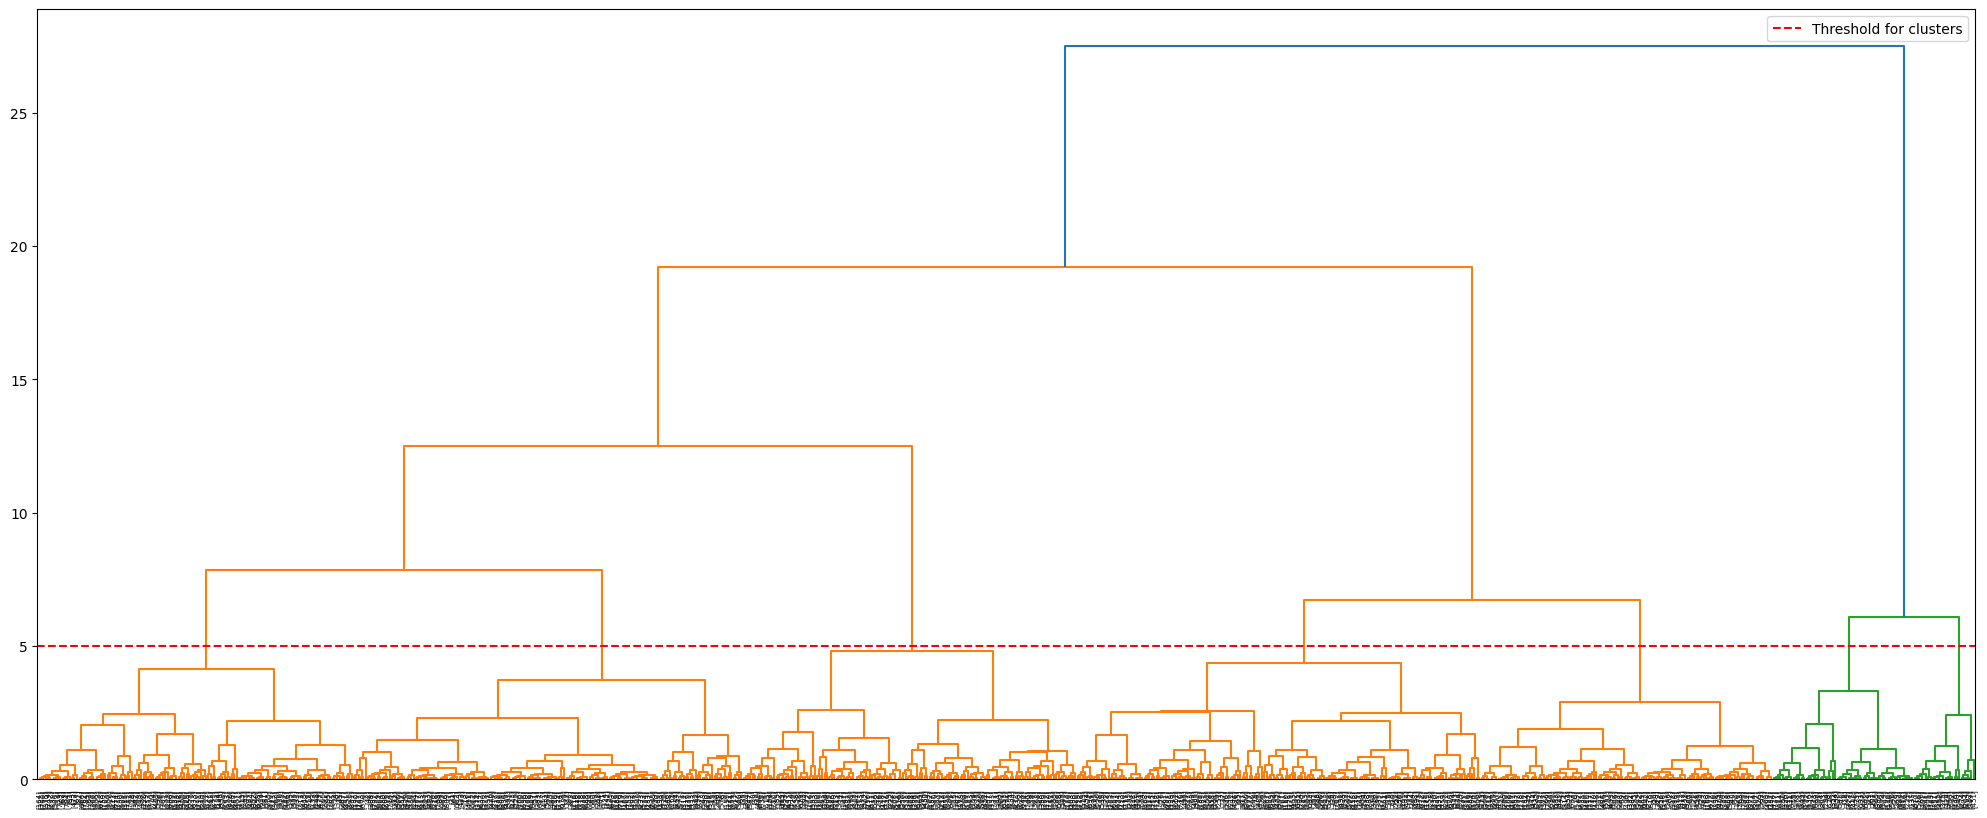

In [22]:
# Параметры для построения дендрограммы
matrix_dend = matrix_.T
fig = plt.figure(figsize=(25, 10))

# Построение дендрограммы
dn = dendrogram(
    matrix_dend,
    orientation='top',
    labels=[[i] for i in range(len_dend)],
    show_leaf_counts=True
)

# Добавление горизонтальной линии для отсечки
plt.axhline(y=5, color='r', linestyle='--', label='Threshold for clusters')

# Добавление легенды
plt.legend()

# Отображение графика
plt.show()

***Автоматический алгоритм***

In [19]:
# кластеризация
time_ = datetime.datetime.now()
clustering = AgglomerativeClustering(n_clusters=num_clast_fish, linkage='complete').fit(X_fish)
time__ = datetime.datetime.now()
time_ier_lib_fish = time__ - time_

# обработка выхода 
df_ier_fish = X_fish.copy()
df_ier_fish['flag'] = list(clustering.labels_)

# оценка точности
inner_ier_lib_fish = inner_clus(df_ier_fish, list(df_ier_fish['flag'].unique()))
outer_ier_lib_fish = outer_clus(df_ier_fish, list(df_ier_fish['flag'].unique()))

print(f'Внутрикластерное расстояние у иерархического алгоритма (библиотека): {inner_ier_lib_fish}',
      f'Межкластерное расстояние у иерархического алгоритма (библиотека): {outer_ier_lib_fish}',
      f'Время работы у иерархического алгоритма (библиотека): {time_ier_lib_fish.microseconds}',
      sep='\n')

Внутрикластерное расстояние у иерархического алгоритма (библиотека): 1296.8668606834253
Межкластерное расстояние у иерархического алгоритма (библиотека): 21602.788252350874
Время работы у иерархического алгоритма (библиотека): 11968


(811, 2)


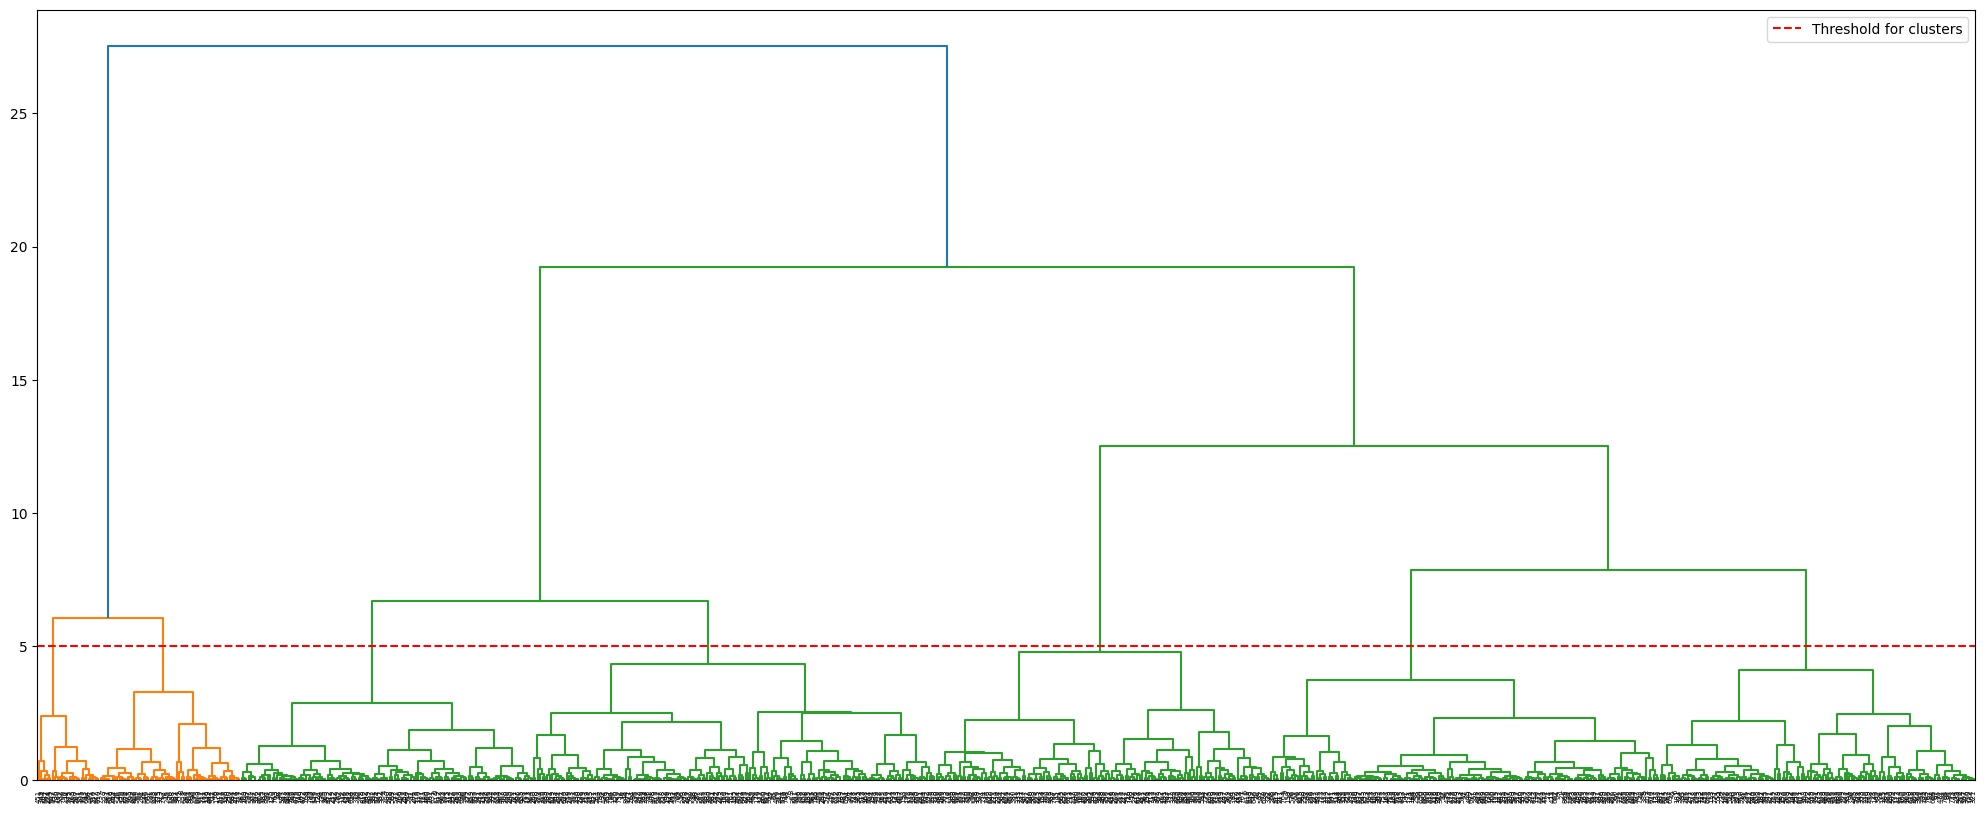

In [21]:
# Проверка данных
print(X_fish.shape)

# Вычисление матрицы связей
Z = linkage(X_fish, method='complete')

# Построение дендрограммы
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

# Добавление горизонтальной линии для отсечки
plt.axhline(y=5, color='r', linestyle='--', label='Threshold for clusters')

# Отображение графика
plt.legend()
plt.show()


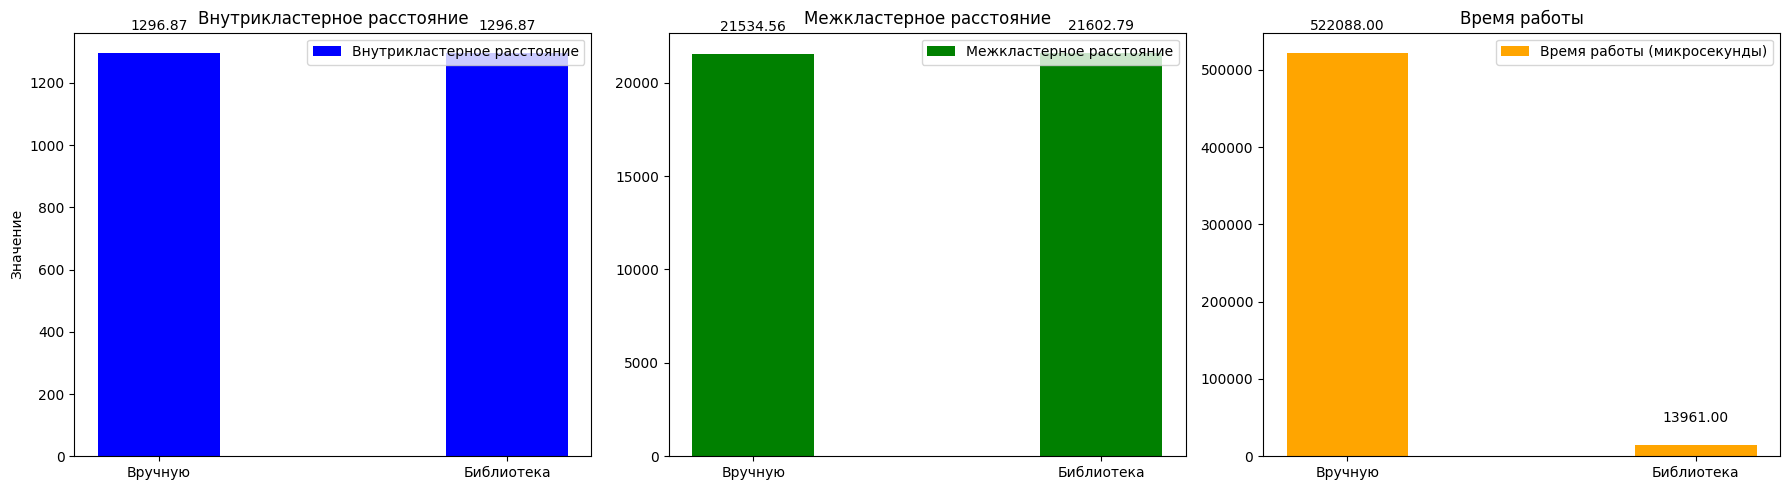

In [17]:
labels = ['Вручную', 'Библиотека']
width = 0.35

# Данные
inner_data = [inner_ier_hand_fish_, inner_ier_lib_fish]
outer_data = [outer_ier_hand_fish_, outer_ier_lib_fish]
time_data = [time_ier_hand_fish_.microseconds, time_ier_lib_fish.microseconds]

# Создание графиков
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# Внутрикластерное расстояние
axes[0].bar(labels, inner_data, width, label='Внутрикластерное расстояние', color='blue')
axes[0].set_title('Внутрикластерное расстояние')
axes[0].set_ylabel('Значение')
axes[0].legend()

# Межкластерное расстояние
axes[1].bar(labels, outer_data, width, label='Межкластерное расстояние', color='green')
axes[1].set_title('Межкластерное расстояние')
axes[1].legend()

# Время работы
axes[2].bar(labels, time_data, width, label='Время работы (микросекунды)', color='orange')
axes[2].set_title('Время работы')
axes[2].legend()

# Добавление подписей на столбцы
for ax, data in zip(axes, [inner_data, outer_data, time_data]):
    for i, v in enumerate(data):
        ax.text(i, v + 0.05 * max(data), f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Text(0.5, 1.02, 'Кластеры (Вручную)')

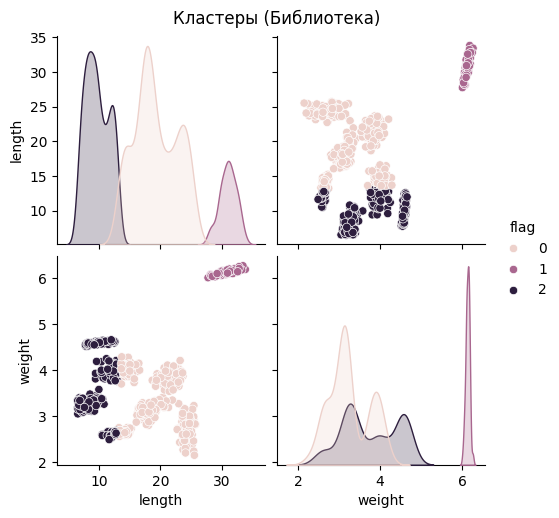

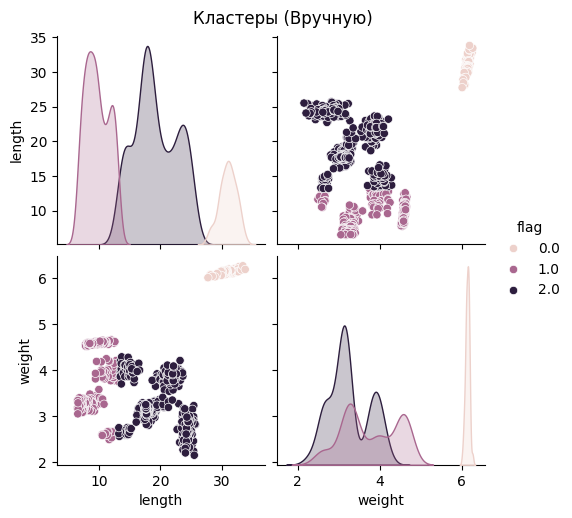

In [43]:
g1 = sns.pairplot(df_ier_fish, hue='flag')
g1.fig.suptitle('Кластеры (Библиотека)', y=1.02)

g2 = sns.pairplot(df_ier_fish_, hue='flag')
g2.fig.suptitle('Кластеры (Вручную)', y=1.02)


## Кластеризация ириса

***Ручная кластеризация***

In [28]:
# Кластеризация
time_ = datetime.datetime.now()
cl, matrix_, num_clast_iris = hier(cluster_df_iris)  # Ваш алгоритм кластеризации
time__ = datetime.datetime.now()
time_ier_hand_iris_ = time__ - time_

# Обработка кластеров
rows = []
for _ in range(len(cl)):
    list_ = post_process(cl[_])  # Обработка кластера
    str_ = create_str(list_)  # Преобразование в строки
    for s_ in str_:
        s_.append(_)  # Добавление метки кластера
        rows.append(s_)

# Создание DataFrame из списка строк
df_ier_iris_ = pd.DataFrame(rows, columns=X_iris.columns.tolist() + ['flag'])

# Вычисление метрик точности
inner_ier_hand_iris_ = inner_clus(df_ier_iris_, list(df_ier_iris_['flag'].unique()))
outer_ier_hand_iris_ = outer_clus(df_ier_iris_, list(df_ier_iris_['flag'].unique()))


In [71]:
# Вывод результатов
print(f'Внутрикластерное расстояние у иерархического алгоритма (вручную): {inner_ier_hand_iris_}')
print(f'Межкластерное расстояние у иерархического алгоритма (вручную): {outer_ier_hand_iris_}')
print(f'Время работы у иерархического алгоритма (вручную): {time_ier_hand_iris_.microseconds} микросекунд')

Внутрикластерное расстояние у иерархического алгоритма (вручную): 69.24563758419474
Межкластерное расстояние у иерархического алгоритма (вручную): 1067.5786375731197
Время работы у иерархического алгоритма (вручную): 462730 микросекунд


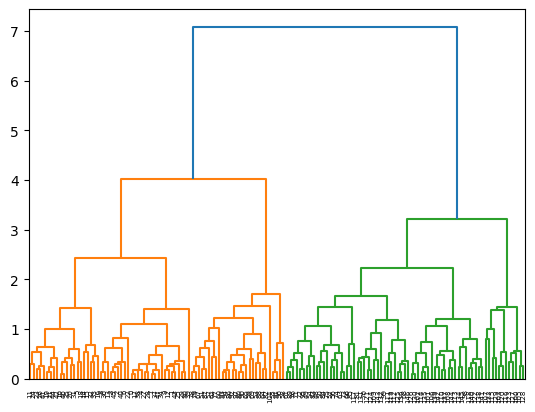

In [154]:
N = Z.shape[0] + 1  
labels = [str(i) for i in range(N)]

dendrogram(Z, labels=labels)
plt.show()


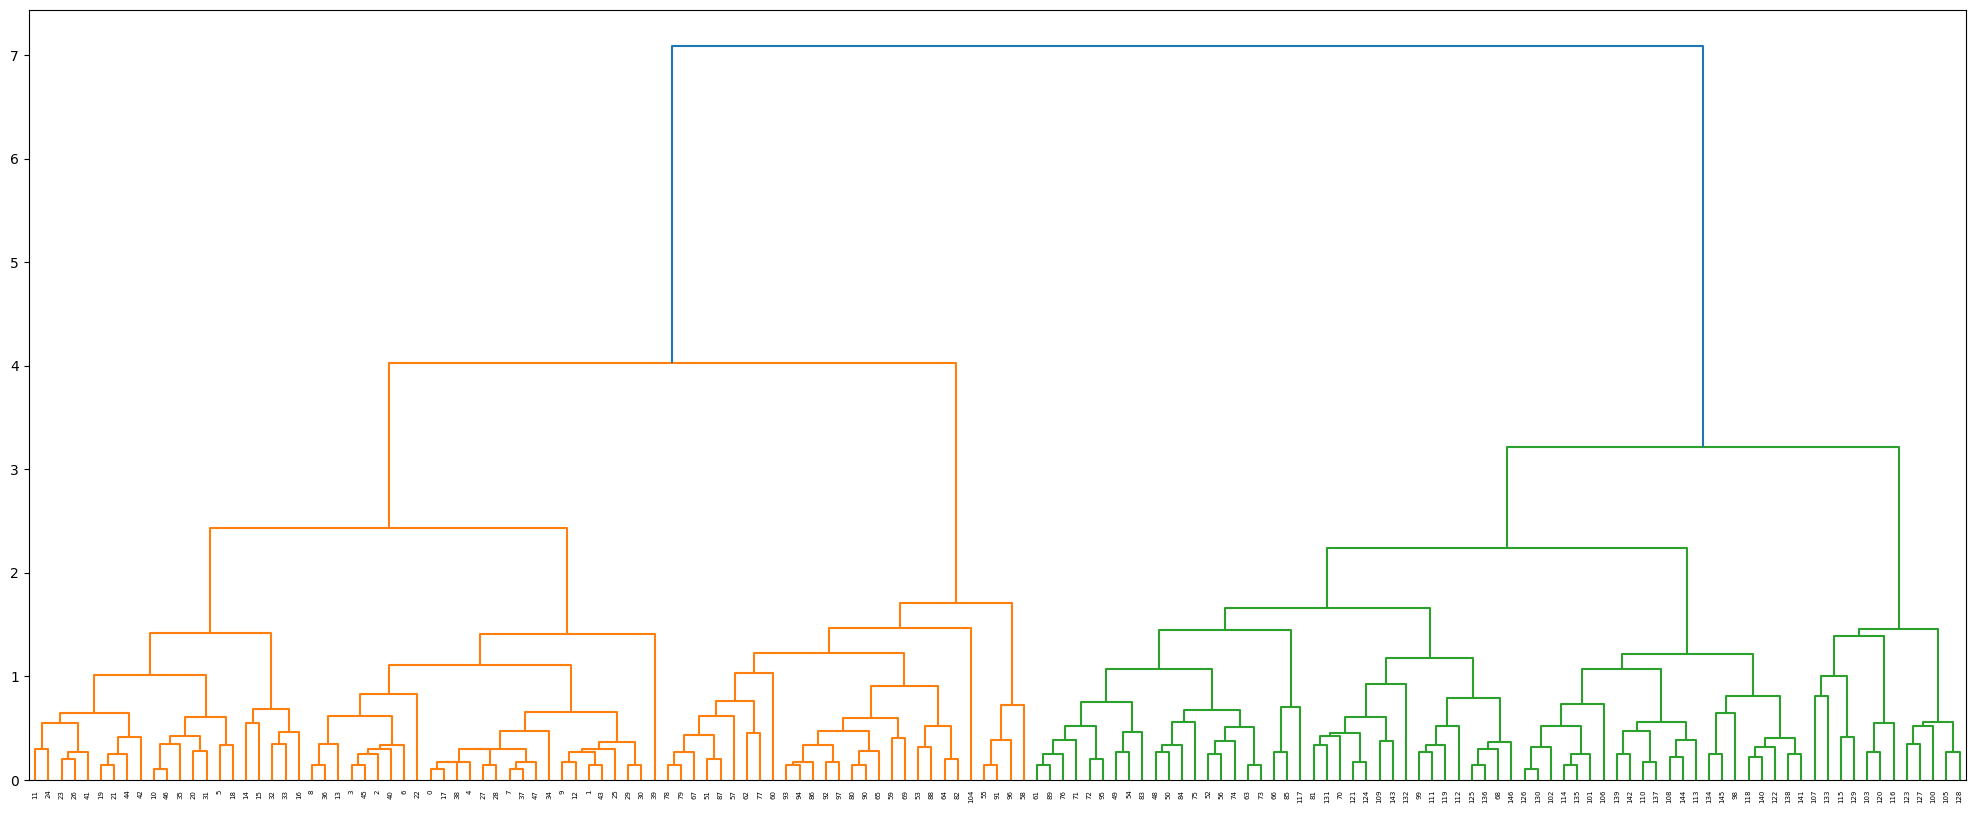

In [155]:
Z = matrix_.T
N = Z.shape[0] + 1 

labels = [str(i) for i in range(N)]  # 147 меток

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z, orientation='top', labels=labels, show_leaf_counts=True)
plt.show()


***Автоматическая кластеризация***

In [29]:
# кластеризация
time_ = datetime.datetime.now()
clustering = AgglomerativeClustering(n_clusters=num_clast_iris, linkage='complete').fit(X_iris)
time__ = datetime.datetime.now()
time_ier_lib_iris = time__ - time_

# обработка выхода 
df_ier_iris = X_iris.copy()
df_ier_iris['flag'] = list(clustering.labels_)

# оценка точности
inner_ier_lib_iris = inner_clus(df_ier_iris, list(df_ier_iris['flag'].unique()))
outer_ier_lib_iris = outer_clus(df_ier_iris, list(df_ier_iris['flag'].unique()))

print(f'Внутрикластерное расстояние у иерархического алгоритма (библиотека): {inner_ier_lib_iris}',
      f'Межкластерное расстояние у иерархического алгоритма (библиотека): {outer_ier_lib_iris}',
      f'Время работы у иерархического алгоритма (библиотека): {time_ier_lib_iris.microseconds}',
      sep='\n')

Внутрикластерное расстояние у иерархического алгоритма (библиотека): 69.24563758419475
Межкластерное расстояние у иерархического алгоритма (библиотека): 1067.5786375731195
Время работы у иерархического алгоритма (библиотека): 2508


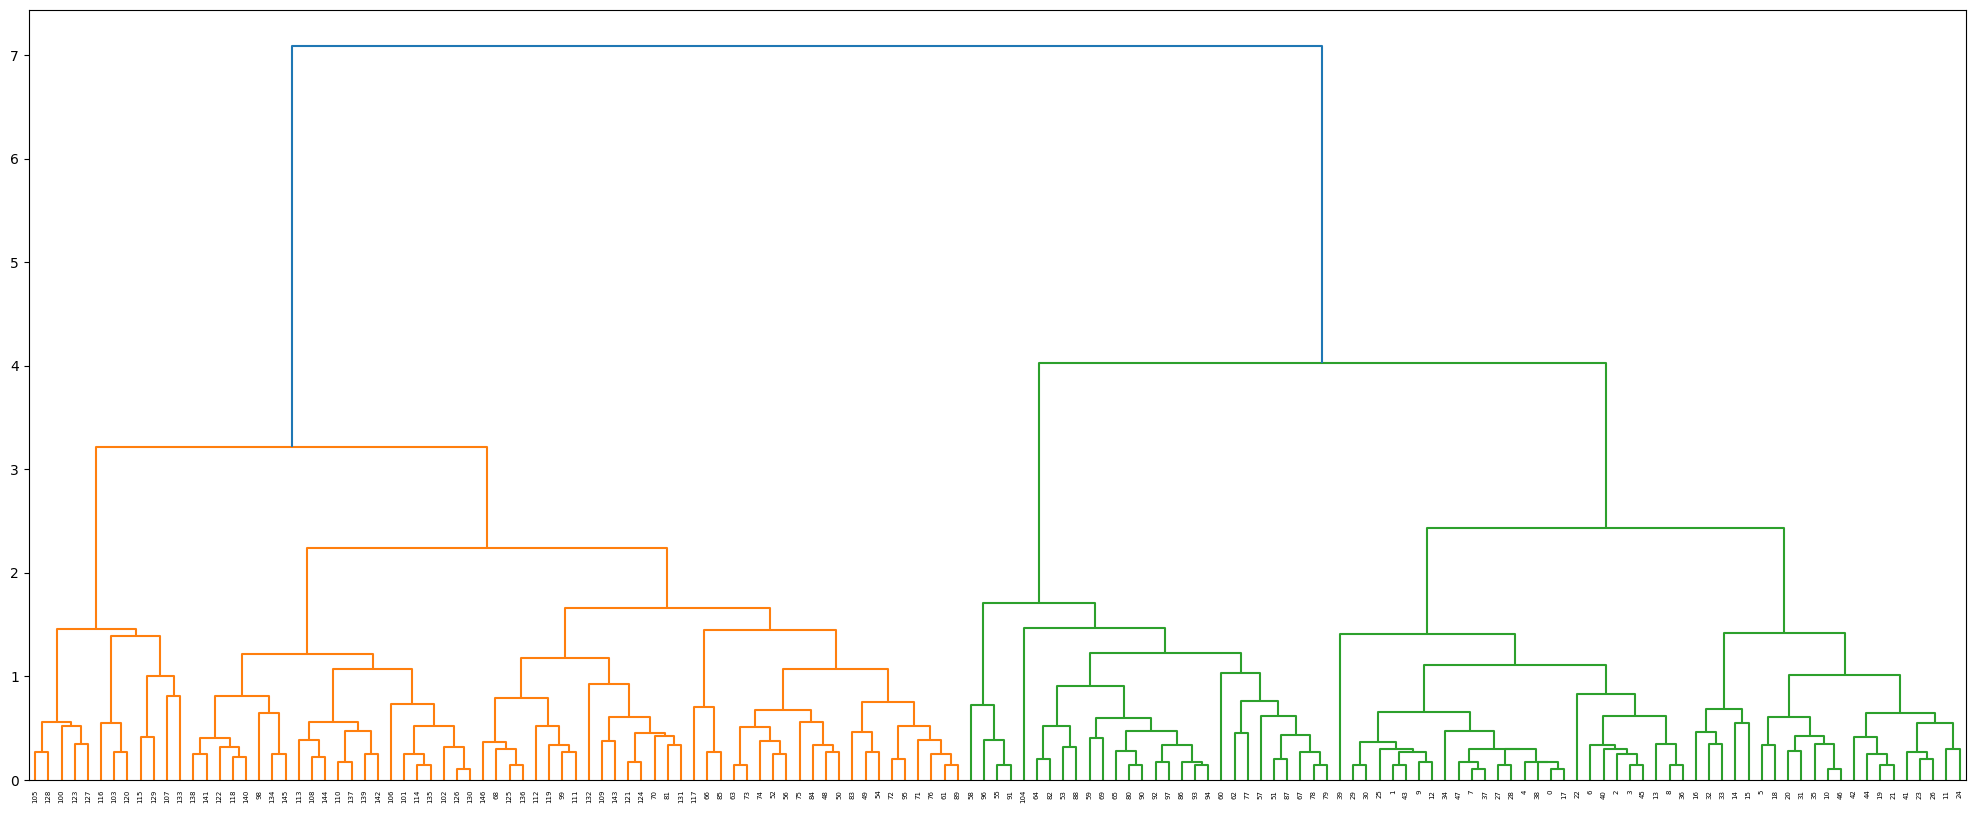

In [81]:
Z = linkage(X_iris, 'complete')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

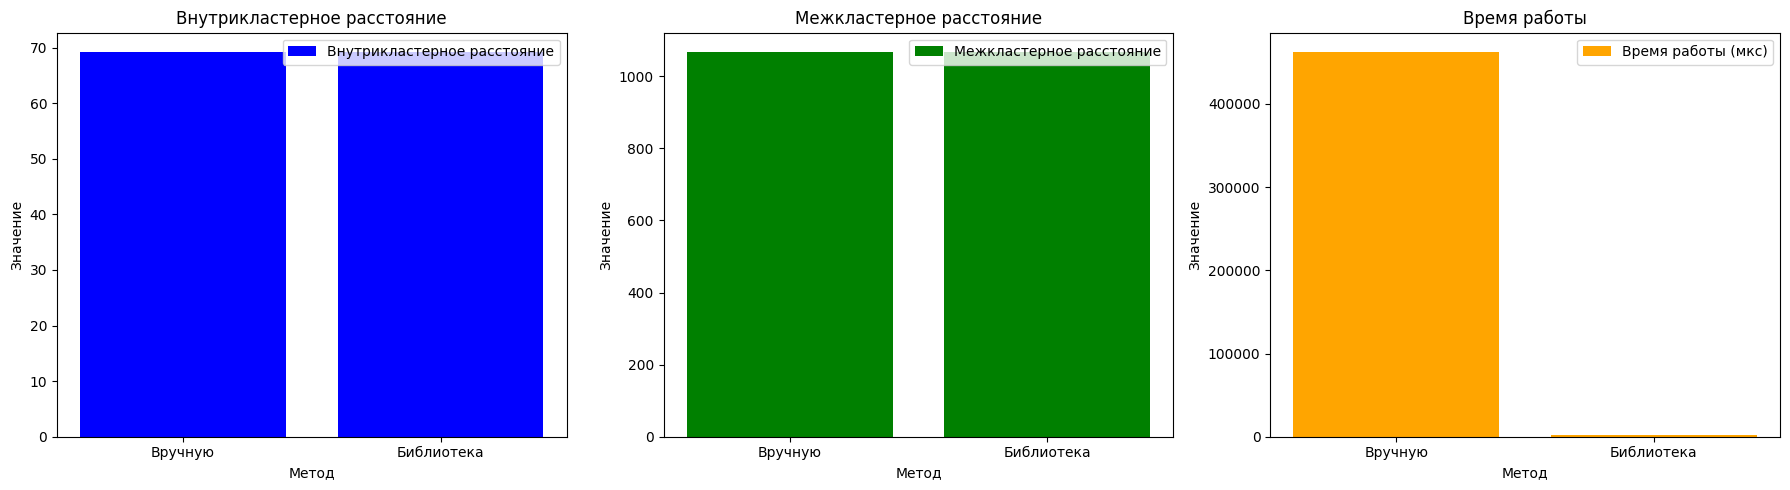

In [90]:


# Данные
categories = ['Вручную', 'Библиотека']
inner_distances = [inner_ier_hand_iris_, inner_ier_lib_iris]
outer_distances = [outer_ier_hand_iris_, outer_ier_lib_iris]
times = [time_ier_hand_iris_.microseconds, time_ier_lib_iris.microseconds]

# Построение графиков
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# Внутрикластерное расстояние
axes[0].bar(categories, inner_distances, color='blue', label='Внутрикластерное расстояние')
axes[0].set_title('Внутрикластерное расстояние')
axes[0].legend()

# Межкластерное расстояние
axes[1].bar(categories, outer_distances, color='green', label='Межкластерное расстояние')
axes[1].set_title('Межкластерное расстояние')
axes[1].legend()

# Время работы
axes[2].bar(categories, times, color='orange', label='Время работы (мкс)')
axes[2].set_title('Время работы')
axes[2].legend()

# Общие настройки
for ax in axes:
    ax.set_xlabel('Метод')
    ax.set_ylabel('Значение')

plt.tight_layout()
plt.show()


Text(0.5, 1.02, 'Кластеры (Вручную)')

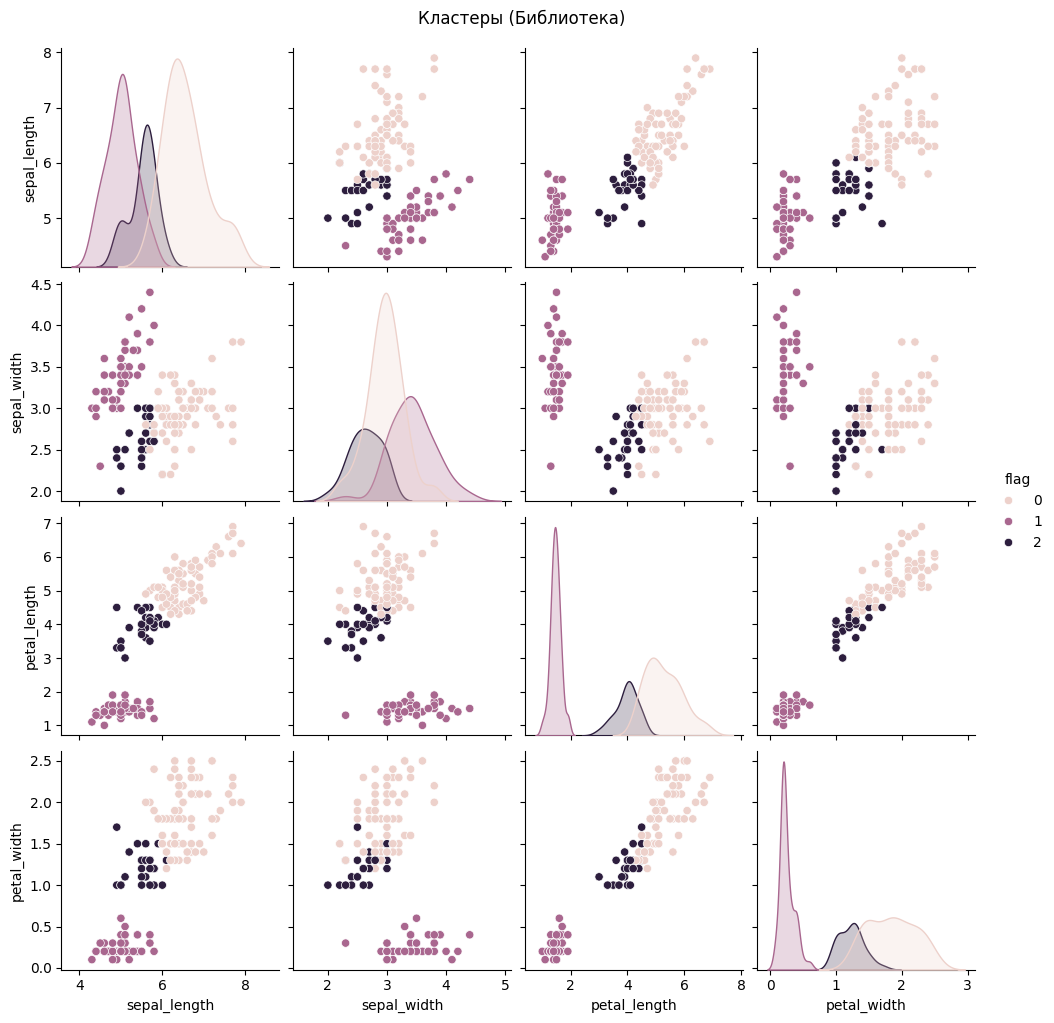

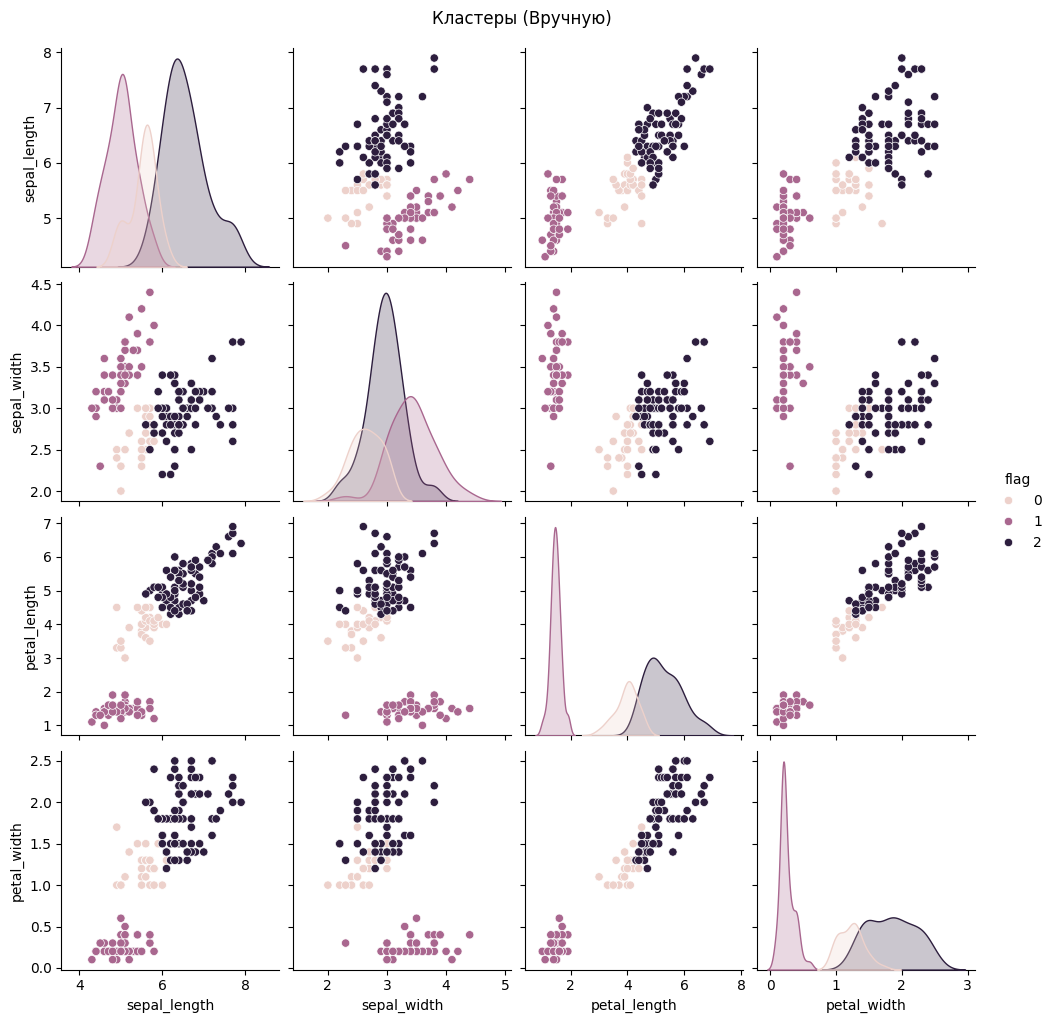

In [91]:
g1 = sns.pairplot(df_ier_iris, hue='flag')
g1.fig.suptitle('Кластеры (Библиотека)', y=1.02)

g2 = sns.pairplot(df_ier_iris_, hue='flag')
g2.fig.suptitle('Кластеры (Вручную)', y=1.02)


# EM-алгоритм

In [24]:
# преобразование данных входа в необходимый вид
cluster_df_fish = []

for idx_1, row_1 in X_fish.iterrows():
    cluster_df_fish.append(tuple(row_1))

cluster_df_iris = []

for idx_2, row_2 in X_iris.iterrows():
    cluster_df_iris.append(tuple(row_2))

In [25]:
def em(data, N, K, M, delta, iter_max):
    # начальные приближения
    w = [1 / K for _ in range(K)]
    m = [random.choice(data) for _ in range(K)]
    row = []
    sum_ = 0
    iter_m = 0
    for k in range(K):
        for i in range(N):
            sum_ += np.linalg.norm(np.array(data[i]) - np.array(m[iter_m]))
        iter_m += 1
        row.append(sum_ / (N * K))
    matrix = [np.diag([row[i]] * M) for i in range(K)]

    y_i = []
    iter_ = 0
    go_on = True

    while go_on is True:
        # e-шаг
        sigma = []
        matrix_1 = []
        for k in range(K):
            sigma_k = np.linalg.det(matrix[k])
            sigma.append(max(sigma_k, 1e-6))  # Ограничение минимального значения sigma

        gamma = dict()
        for k in range(K):
            gamma[k] = []

        for n in range(N):
            p_x = []
            for k in range(K):
                mat_mul = np.linalg.norm(np.array(data[n]) - np.array(m[k]))**2
                mat_mul = min(mat_mul, 1e6)  # Ограничение mat_mul
                
                # Используем логарифмы для избежания переполнения
                log_p_x_ = -0.5 * mat_mul - 0.5 * np.log(2 * np.pi) * M - 0.5 * np.log(sigma[k])
                p_x_ = np.exp(log_p_x_)
                p_x.append(p_x_)

            for k in range(K):
                gamma[k].append(w[k] * p_x[k] / sum([w[_] * p_x[_] for _ in range(K)]))

        # m-шаг
        w = []
        m = []
        matrix = []
        for k in range(K):
            n_k = sum(gamma[k])

            w.append(n_k / N)

            vect = []
            for j in range(M):
                mult = []
                for n in range(N):
                    mult.append(np.array(data[n])[j] * gamma[k][n])
                vect.append(sum(mult))

            m.append(np.array(vect) / (N * w[-1]))

            sigma = []
            for j in range(M):
                mult = []
                for n in range(N):
                    mult.append(gamma[k][n] * (np.array(data[n])[j] - m[k][j]) ** 2)

                sigma.append(sum(mult) / (N * w[-1]))
            matrix.append(np.diag(sigma))

        y_i_ = []
        clus = dict()
        for n in range(N):
            prob = dict()
            for k in range(K):
                prob[k] = gamma[k][n]

            max_p = max(prob.values())
            y_i_.append(max_p)

            for key, value in prob.items():
                if value == max_p:
                    clus[n] = key
                    break
        y_i.append(y_i_)

        if iter_ > 0:
            num_ = 0
            for _ in range(len(y_i_)):
                delta_ = abs(y_i[-2][_] - y_i[-1][_])
                if delta_ > delta:
                    num_ += 1
            if num_ == 0:
                go_on = False

        iter_ += 1
    return clus


## Кластеризация рыб

***Ручная кластеризация***

In [96]:
# кластеризация
time_ = datetime.datetime.now()
clust = em(cluster_df_fish, len(cluster_df_fish), num_clast_fish, 2, 0.01, 100)
time__ = datetime.datetime.now()
time_em_hand_fish_ = time__ - time_

# постобработка
df_em_fish_ = X_fish.copy()
df_em_fish_['flag'] = list(clust.values())

# оценка точности прописаный алгоритм
inner_em_hand_fish_ = inner_clus(df_em_fish_, list(df_em_fish_['flag'].unique()))
outer_em_hand_fish_ = outer_clus(df_em_fish_, list(df_em_fish_['flag'].unique()))

print(f'Внутрикластерное расстояние у ем алгоритма (библиотека): {inner_em_hand_fish_}',
      f'Межкластерное расстояние у ем алгоритма (библиотека): {outer_em_hand_fish_}',
      f'Время работы у ем алгоритма (библиотека): {time_em_hand_fish_.microseconds}',
      sep='\n')

Внутрикластерное расстояние у ем алгоритма (библиотека): 1233.6127855211025
Межкластерное расстояние у ем алгоритма (библиотека): 21502.953735903982
Время работы у ем алгоритма (библиотека): 304076


***Автоматическая кластеризация***

In [100]:
# кластеризация
time_ = datetime.datetime.now()
gm = GaussianMixture(n_components=num_clast_fish, random_state=24).fit(X_fish)
time__ = datetime.datetime.now()
time_em_lib_fish = time__ - time_

# постобработка
flag = gm.predict(X_fish)
df_em_fish = X_fish.copy()
df_em_fish['flag'] = list(flag)

# библиотечный алгоритм

inner_em_lib_fish = inner_clus(df_em_fish, list(df_em_fish['flag'].unique()))
outer_em_lib_fish = outer_clus(df_em_fish, list(df_em_fish['flag'].unique()))

print(f'Внутрикластерное расстояние у ем алгоритма (библиотека): {inner_em_lib_fish}',
      f'Межкластерное расстояние у ем алгоритма (библиотека): {outer_em_lib_fish}',
      f'Время работы у ем алгоритма (библиотека): {time_em_lib_fish.microseconds}',
      sep='\n')

Внутрикластерное расстояние у ем алгоритма (библиотека): 1366.2229940609502
Межкластерное расстояние у ем алгоритма (библиотека): 21445.34086343496
Время работы у ем алгоритма (библиотека): 68000


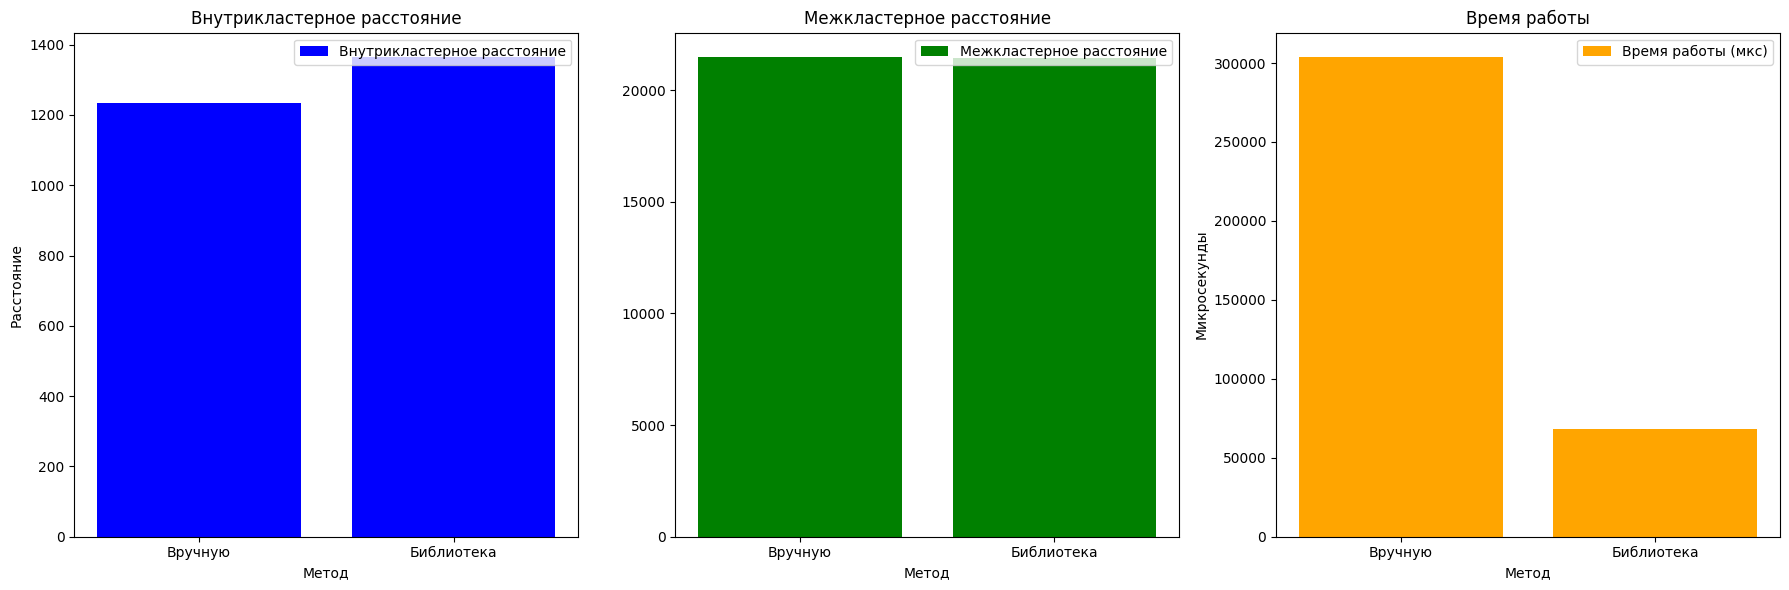

In [101]:


# Данные
categories = ['Вручную', 'Библиотека']
inner_distances = [inner_em_hand_fish_, inner_em_lib_fish]
outer_distances = [outer_em_hand_fish_, outer_em_lib_fish]
times = [time_em_hand_fish_.microseconds, time_em_lib_fish.microseconds]

# Построение графиков
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# Внутрикластерное расстояние
axes[0].bar(categories, inner_distances, color='blue', label='Внутрикластерное расстояние')
axes[0].set_title('Внутрикластерное расстояние')
axes[0].set_ylabel('Расстояние')
axes[0].legend()

# Межкластерное расстояние
axes[1].bar(categories, outer_distances, color='green', label='Межкластерное расстояние')
axes[1].set_title('Межкластерное расстояние')
axes[1].legend()

# Время выполнения
axes[2].bar(categories, times, color='orange', label='Время работы (мкс)')
axes[2].set_title('Время работы')
axes[2].set_ylabel('Микросекунды')
axes[2].legend()

# Настройка общих параметров
for ax in axes:
    ax.set_xlabel('Метод')
    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories)

plt.tight_layout()
plt.show()


Text(0.5, 1.02, 'Кластеры (Ручной EM)')

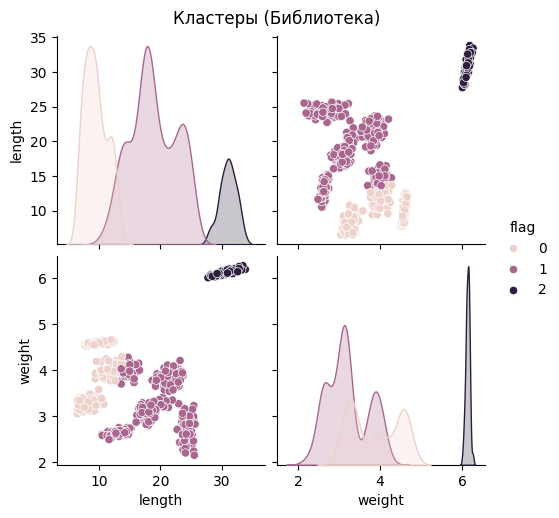

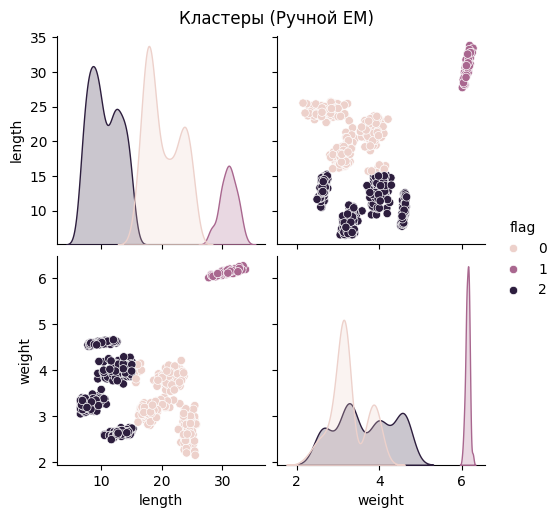

In [102]:
g1 = sns.pairplot(df_em_fish, hue='flag')
g1.fig.suptitle('Кластеры (Библиотека)', y=1.02)

g2 = sns.pairplot(df_em_fish_, hue='flag')
g2.fig.suptitle('Кластеры (Ручной EM)', y=1.02)


## Кластеризация ириса

***Ручная кластеризация***

In [32]:
# кластеризация
time_ = datetime.datetime.now()
clust = em(cluster_df_iris, len(cluster_df_iris), num_clast_iris, 4, 0.0001, 100)
time__ = datetime.datetime.now()
time_em_hand_iris_ = time__ - time_

# постобработка
df_em_iris_ = X_iris.copy()
df_em_iris_['flag'] = list(clust.values())

# оценка точности прописаный алгоритм
inner_em_hand_iris_ = inner_clus(df_em_iris_, list(df_em_iris_['flag'].unique()))
outer_em_hand_iris_ = outer_clus(df_em_iris_, list(df_em_iris_['flag'].unique()))

print(f'Внутрикластерное расстояние у ем алгоритма (вручную): {inner_em_hand_iris_}',
      f'Межкластерное расстояние у ем алгоритма (вручную): {outer_em_hand_iris_}',
      f'Время работы у ем алгоритма (вручную): {time_em_hand_iris_.microseconds}',
      sep='\n')

Внутрикластерное расстояние у ем алгоритма (вручную): 89.23122330600778
Межкластерное расстояние у ем алгоритма (вручную): 609.8364815003295
Время работы у ем алгоритма (вручную): 137172


In [104]:
# кластеризация
time_ = datetime.datetime.now()
gm = GaussianMixture(n_components=num_clast_iris, random_state=24).fit(X_iris)
time__ = datetime.datetime.now()
time_em_lib_iris = time__ - time_

# постобработка
flag = gm.predict(X_iris)
df_em_iris = X_iris.copy()
df_em_iris['flag'] = list(flag)

# библиотечный алгоритм

inner_em_lib_iris = inner_clus(df_em_iris, list(df_em_iris['flag'].unique()))
outer_em_lib_iris = outer_clus(df_em_iris, list(df_em_iris['flag'].unique()))

print(f'Внутрикластерное расстояние у ем алгоритма (библиотека): {inner_em_lib_iris}',
      f'Межкластерное расстояние у ем алгоритма (библиотека): {outer_em_lib_iris}',
      f'Время работы у ем алгоритма (библиотека): {time_em_lib_iris.microseconds}',
      sep='\n')

Внутрикластерное расстояние у ем алгоритма (библиотека): 69.46833732502265
Межкластерное расстояние у ем алгоритма (библиотека): 1086.3004837712463
Время работы у ем алгоритма (библиотека): 27005


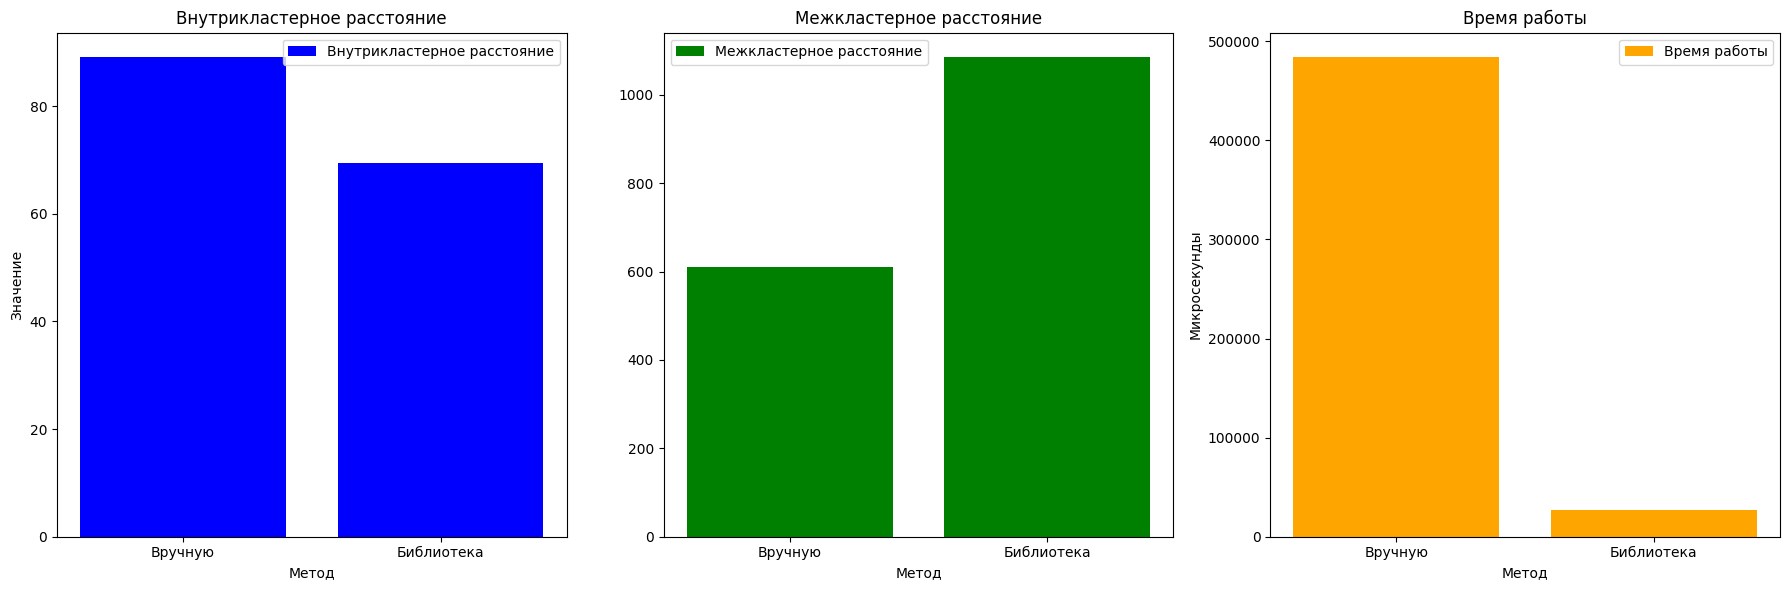

In [106]:
# Данные
categories = ['Вручную', 'Библиотека']
inner_distances = [inner_em_hand_iris_, inner_em_lib_iris]
outer_distances = [outer_em_hand_iris_, outer_em_lib_iris]
times = [time_em_hand_iris_.microseconds, time_em_lib_iris.microseconds]

# Создание фигуры с тремя подграфиками
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# Внутрикластерное расстояние
axes[0].bar(categories, inner_distances, color='blue', label='Внутрикластерное расстояние')
axes[0].set_title('Внутрикластерное расстояние')
axes[0].set_ylabel('Значение')
axes[0].legend()

# Межкластерное расстояние
axes[1].bar(categories, outer_distances, color='green', label='Межкластерное расстояние')
axes[1].set_title('Межкластерное расстояние')
axes[1].legend()

# Время выполнения
axes[2].bar(categories, times, color='orange', label='Время работы')
axes[2].set_title('Время работы')
axes[2].set_ylabel('Микросекунды')
axes[2].legend()

# Настройка общих параметров
for ax in axes:
    ax.set_xlabel('Метод')
    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories)

plt.tight_layout()
plt.show()


Text(0.5, 1.02, 'Кластеры (Ручной EM)')

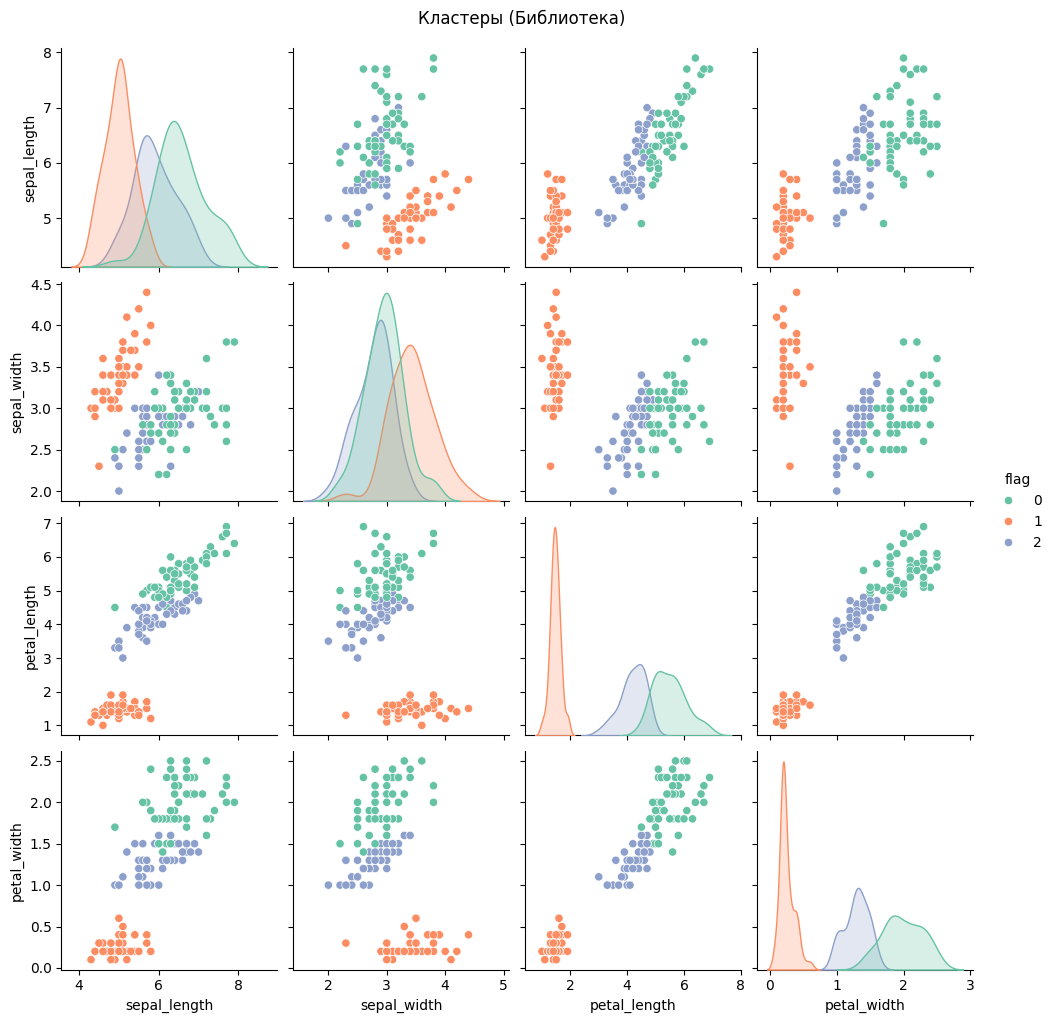

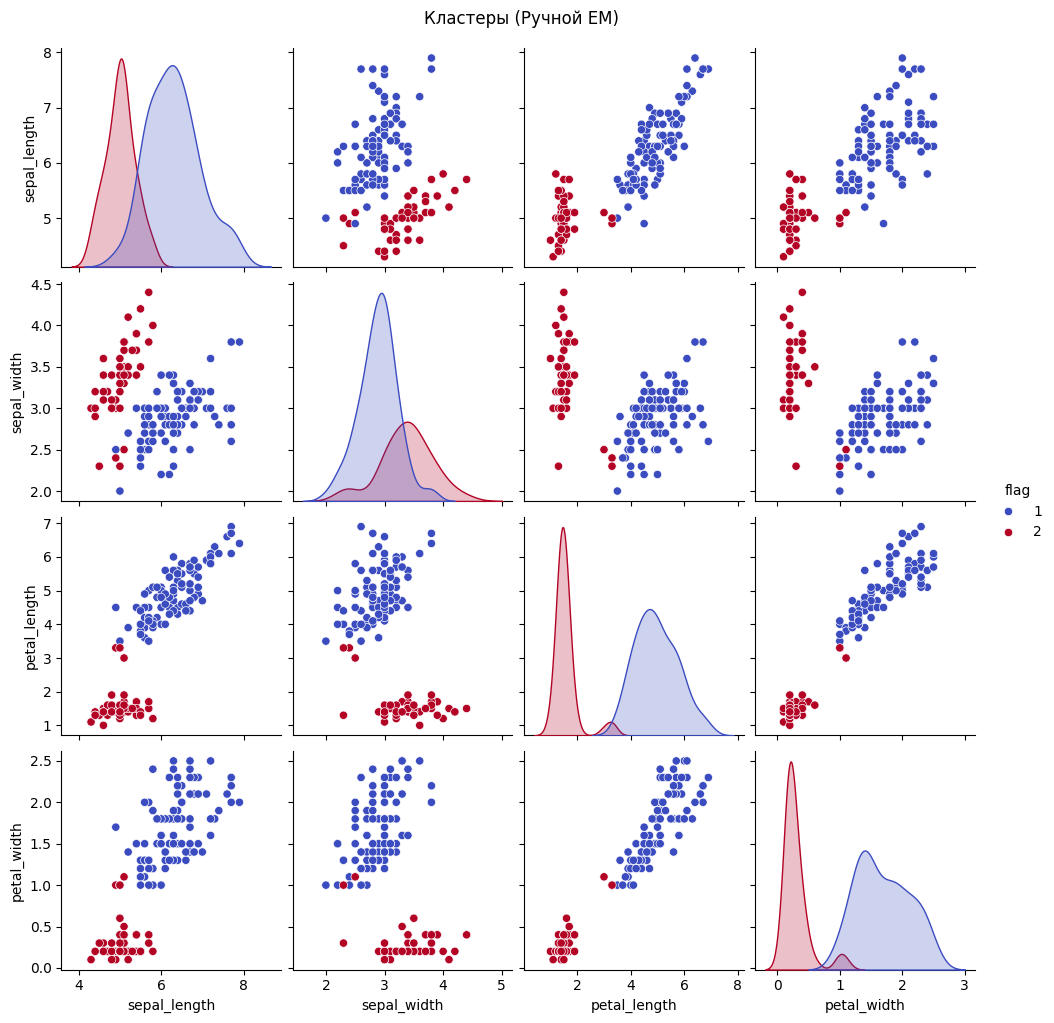

In [107]:
g1 = sns.pairplot(df_em_iris, hue='flag', palette='Set2')
g1.fig.suptitle('Кластеры (Библиотека)', y=1.02)

g2 = sns.pairplot(df_em_iris_, hue='flag', palette='coolwarm')
g2.fig.suptitle('Кластеры (Ручной EM)', y=1.02)


# DBSCAN

In [108]:
# преобразование данных входа в необходимый вид
cluster_df_fish = []

for idx_1, row_1 in X_fish.iterrows():
    cluster_df_fish.append(tuple(row_1))

cluster_df_iris = []

for idx_2, row_2 in X_iris.iterrows():
    cluster_df_iris.append(tuple(row_2))

In [120]:
def dbscan(data, eps, min_samples):
    maybe_noise = 0
    cluster_id = 0

    visited_points = set()
    clustered_points = set()
    clusters = {maybe_noise: []}

    def expand_cluster(point, neighbors):
        if cluster_id not in clusters:
            clusters[cluster_id] = []
        clusters[cluster_id].append(point)
        clustered_points.add(point)

        while neighbors:
            q = neighbors.pop()
            if q not in visited_points:
                visited_points.add(q)
                new_neighbors = [p for p in data if np.linalg.norm(np.array(q) - np.array(p)) < eps]
                if len(new_neighbors) >= min_samples:
                    neighbors.extend(new_neighbors)
            if q not in clustered_points:
                clustered_points.add(q)
                clusters[cluster_id].append(q)
                if q in clusters[maybe_noise]:
                    clusters[maybe_noise].remove(q)

    for point in data:
        if point in visited_points:
            continue
        visited_points.add(point)

        neighbors = [p for p in data if np.linalg.norm(np.array(point) - np.array(p)) < eps]
        if len(neighbors) < min_samples:
            clusters[maybe_noise].append(point)
        else:
            cluster_id += 1
            expand_cluster(point, neighbors)

    return clusters


## Кластеризация рыб

***Ручная кластеризация***

In [121]:
# кластеризация
time_ = datetime.datetime.now()
clust = dbscan(cluster_df_fish, 0.2, 2)
time__ = datetime.datetime.now()
time_dbscan_hand_fish = time__ - time_

# постобработка
df_dbscan_fish = X_fish.copy().head(0)
df_dbscan_fish['flag'] = []
row_num = 0
for key, value in clust.items():
    for v in value:
        row = list(v)
        row.append(key)
        df_dbscan_fish.loc[row_num] = row
        row_num += 1

# прописаный алгоритм

inner_dbscan_hand_fish = inner_clus(df_dbscan_fish, list(df_dbscan_fish['flag'].unique()))
outer_dbscan_hand_fish = outer_clus(df_dbscan_fish, list(df_dbscan_fish['flag'].unique()))

print(f'Внутрикластерное расстояние у dbscan алгоритма (вручную): {inner_dbscan_hand_fish}',
      f'Межкластерное расстояние у dbscan алгоритма (вручную): {outer_dbscan_hand_fish}',
      f'Время работы у dbscan алгоритма (вручную): {time_dbscan_hand_fish.microseconds}',
      sep='\n')

Внутрикластерное расстояние у dbscan алгоритма (вручную): 363.1595384134298
Межкластерное расстояние у dbscan алгоритма (вручную): 807867.6387485993
Время работы у dbscan алгоритма (вручную): 920563


***Автоматическая кластеризаци***

In [122]:
# кластеризация
time_ = datetime.datetime.now()
clustering = DBSCAN(eps=0.2, min_samples=2).fit(X_fish)
flag = clustering.labels_
time__ = datetime.datetime.now()
time_dbscan_alg_fish_ = time__ - time_

# постобработка
df_dbscan_fish_ = X_fish.copy()
df_dbscan_fish_['flag'] = flag

# автоматический алгоритм
inner_dbscan_alg_fish_ = inner_clus(df_dbscan_fish_, list(df_dbscan_fish_['flag'].unique()))
outer_dbscan_alg_fish_ = outer_clus(df_dbscan_fish_, list(df_dbscan_fish_['flag'].unique()))

print(f'Внутрикластерное расстояние у dbscan алгоритма (автоматически): {inner_dbscan_alg_fish_}',
      f'Межкластерное расстояние у dbscan алгоритма (автоматически): {outer_dbscan_alg_fish_}',
      f'Время работы у dbscan алгоритма (автоматически): {time_dbscan_alg_fish_.microseconds}',
      sep='\n')

Внутрикластерное расстояние у dbscan алгоритма (автоматически): 363.1595384134296
Межкластерное расстояние у dbscan алгоритма (автоматически): 807867.6387485998
Время работы у dbscan алгоритма (автоматически): 10002


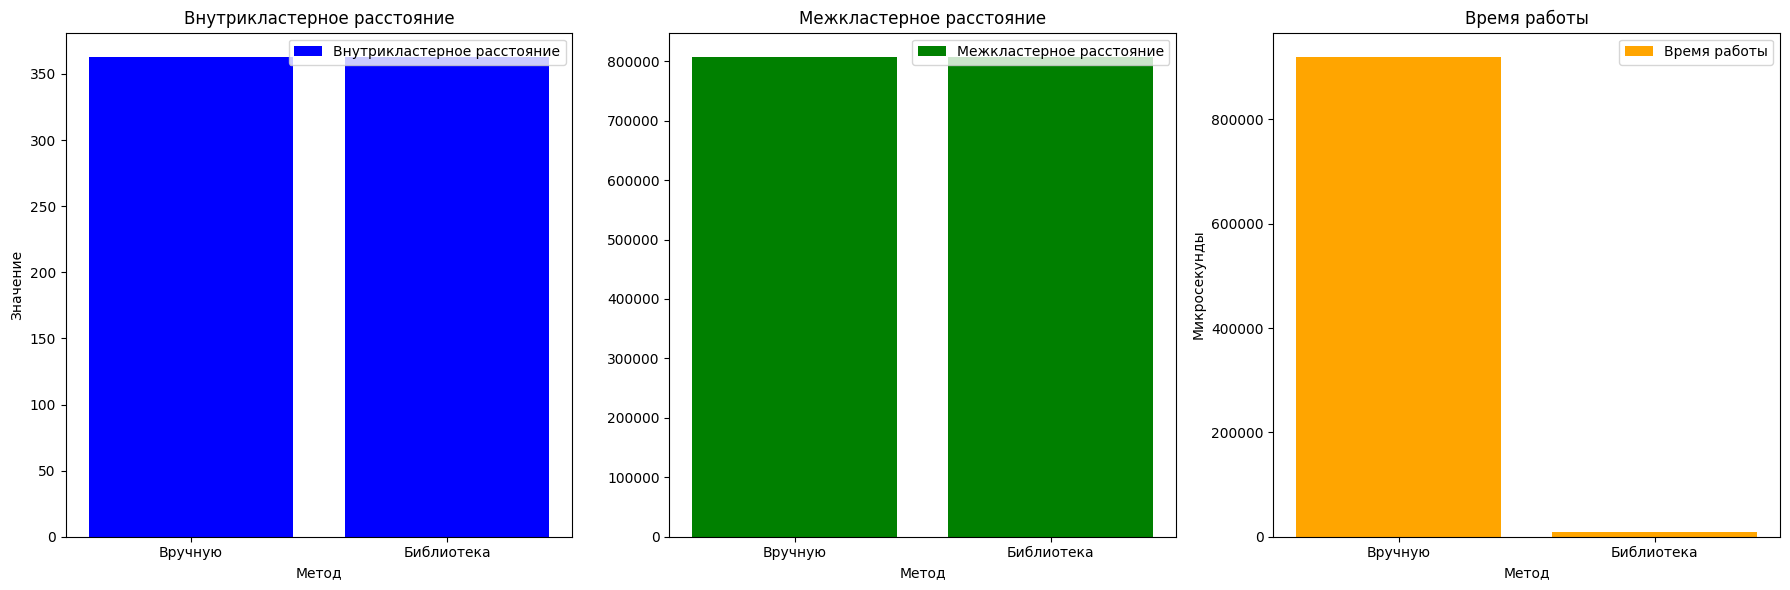

In [123]:
# Данные
categories = ['Вручную', 'Библиотека']
inner_distances = [inner_dbscan_hand_fish, inner_dbscan_alg_fish_]
outer_distances = [outer_dbscan_hand_fish, outer_dbscan_alg_fish_]
times = [time_dbscan_hand_fish.microseconds, time_dbscan_alg_fish_.microseconds]

# Создание фигуры с тремя подграфиками
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# Внутрикластерное расстояние
axes[0].bar(categories, inner_distances, color='blue', label='Внутрикластерное расстояние')
axes[0].set_title('Внутрикластерное расстояние')
axes[0].set_ylabel('Значение')
axes[0].legend()

# Межкластерное расстояние
axes[1].bar(categories, outer_distances, color='green', label='Межкластерное расстояние')
axes[1].set_title('Межкластерное расстояние')
axes[1].legend()

# Время выполнения
axes[2].bar(categories, times, color='orange', label='Время работы')
axes[2].set_title('Время работы')
axes[2].set_ylabel('Микросекунды')
axes[2].legend()

# Настройка меток
for ax in axes:
    ax.set_xlabel('Метод')
    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories)

plt.tight_layout()
plt.show()


Text(0.5, 1.02, 'Кластеры (Библиотечный DBSCAN)')

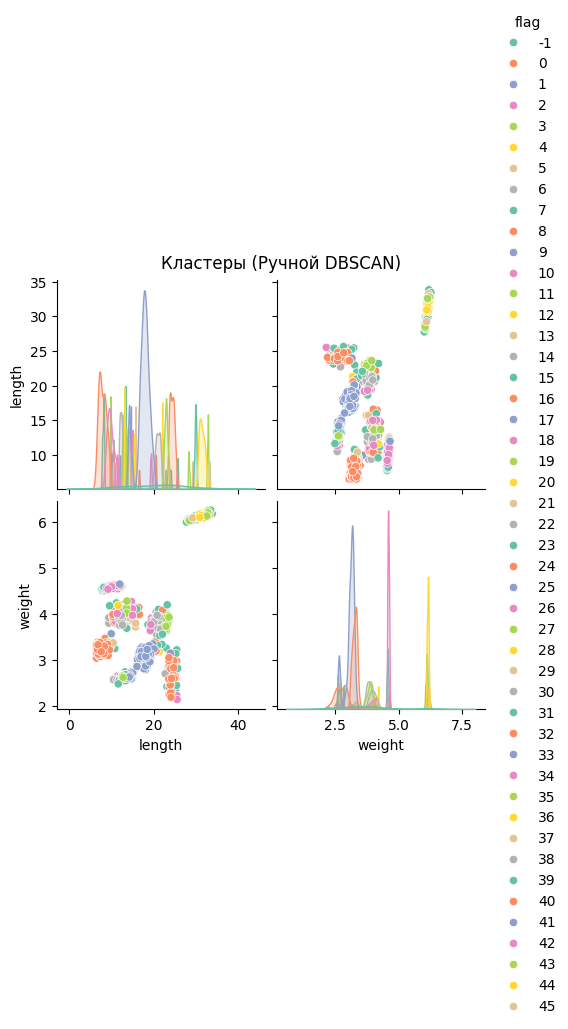

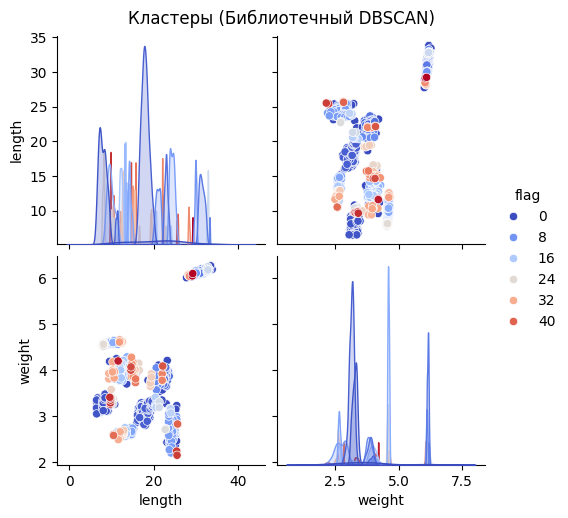

In [124]:
g1 = sns.pairplot(df_dbscan_fish_, hue='flag', palette='Set2')
g1.fig.suptitle('Кластеры (Ручной DBSCAN)', y=1.02)

g2 = sns.pairplot(df_dbscan_fish, hue='flag', palette='coolwarm')
g2.fig.suptitle('Кластеры (Библиотечный DBSCAN)', y=1.02)


## Кластеризация ириса

***Ручная кластеризация***

In [116]:
# кластеризация
time_ = datetime.datetime.now()
clust = dbscan(cluster_df_iris, 0.4, 2)
time__ = datetime.datetime.now()
time_dbscan_hand_iris = time__ - time_

# постобработка
df_dbscan_iris = X_iris.copy().head(0)
df_dbscan_iris['flag'] = []
row_num = 0
for key, value in clust.items():
    for v in value:
        row = list(v)
        row.append(key)
        df_dbscan_iris.loc[row_num] = row
        row_num += 1

# прописаный алгоритм

inner_dbscan_hand_iris = inner_clus(df_dbscan_iris, list(df_dbscan_iris['flag'].unique()))
outer_dbscan_hand_iris = outer_clus(df_dbscan_iris, list(df_dbscan_iris['flag'].unique()))

print(f'Внутрикластерное расстояние у dbscan алгоритма (вручную): {inner_dbscan_hand_iris}',
      f'Межкластерное расстояние у dbscan алгоритма (вручную): {outer_dbscan_hand_iris}',
      f'Время работы у dbscan алгоритма (вручную): {time_dbscan_hand_iris.microseconds}',
      sep='\n')

Внутрикластерное расстояние у dbscan алгоритма (вручную): 69.43968816357007
Межкластерное расстояние у dbscan алгоритма (вручную): 4440.966300482999
Время работы у dbscan алгоритма (вручную): 122709


In [117]:
# кластеризация
time_ = datetime.datetime.now()
clustering = DBSCAN(eps=0.4, min_samples=2).fit(X_iris)
flag = clustering.labels_
time__ = datetime.datetime.now()
time_dbscan_alg_iris_ = time__ - time_

# постобработка
df_dbscan_iris_ = X_iris.copy()
df_dbscan_iris_['flag'] = flag

# автоматический алгоритм
inner_dbscan_alg_iris_ = inner_clus(df_dbscan_iris_, list(df_dbscan_iris_['flag'].unique()))
outer_dbscan_alg_iris_ = outer_clus(df_dbscan_iris_, list(df_dbscan_iris_['flag'].unique()))

print(f'Внутрикластерное расстояние у dbscan алгоритма (автоматически): {inner_dbscan_alg_iris_}',
      f'Межкластерное расстояние у dbscan алгоритма (автоматически): {outer_dbscan_alg_iris_}',
      f'Время работы у dbscan алгоритма (автоматически): {time_dbscan_alg_iris_.microseconds}',
      sep='\n')

Внутрикластерное расстояние у dbscan алгоритма (автоматически): 69.43968816357007
Межкластерное расстояние у dbscan алгоритма (автоматически): 4440.9663004830045
Время работы у dbscan алгоритма (автоматически): 2999


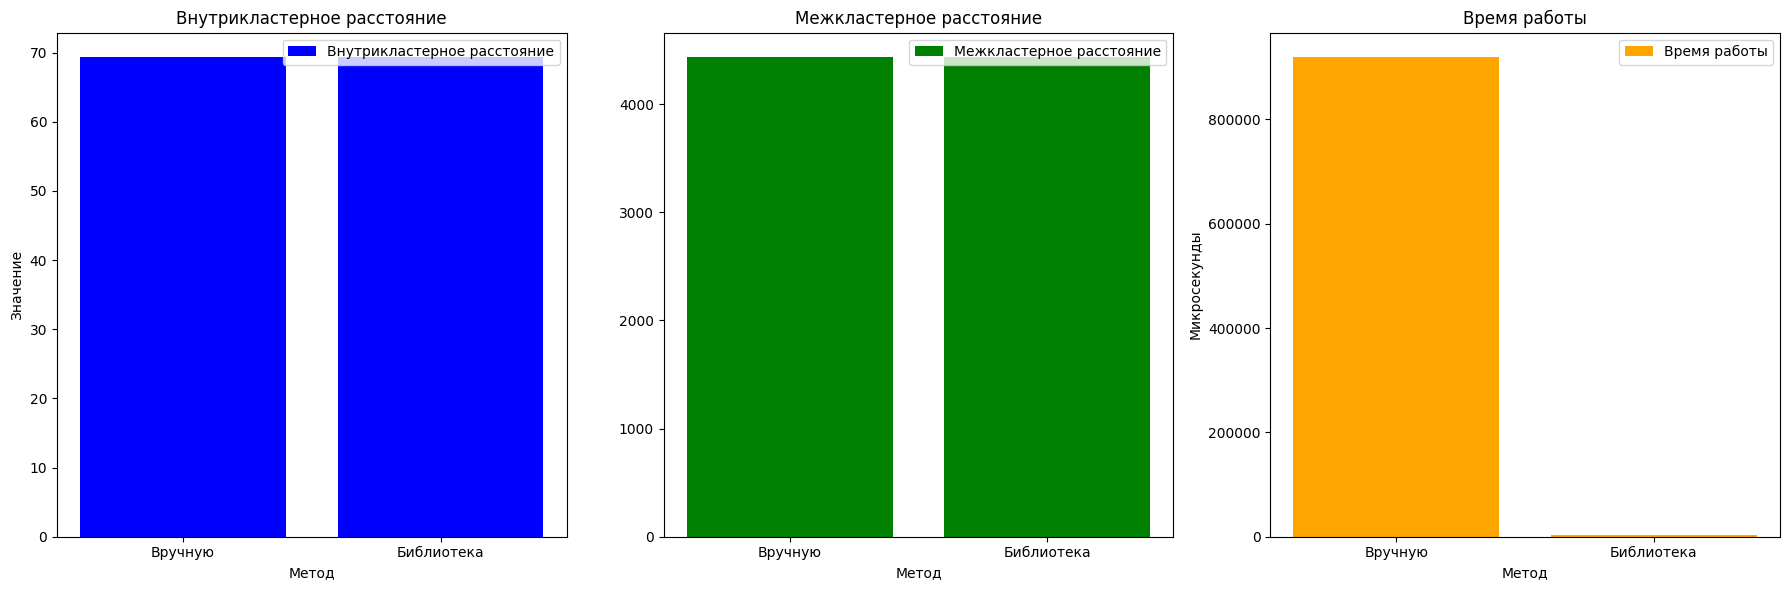

In [125]:
# Данные для сравнения
categories = ['Вручную', 'Библиотека']
inner_distances = [inner_dbscan_hand_iris, inner_dbscan_alg_iris_]
outer_distances = [outer_dbscan_hand_iris, outer_dbscan_alg_iris_]
times = [time_dbscan_hand_fish.microseconds, time_dbscan_alg_iris_.microseconds]

# Создание фигуры с тремя подграфиками
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# Внутрикластерное расстояние
axes[0].bar(categories, inner_distances, color='blue', label='Внутрикластерное расстояние')
axes[0].set_title('Внутрикластерное расстояние')
axes[0].set_ylabel('Значение')
axes[0].legend()

# Межкластерное расстояние
axes[1].bar(categories, outer_distances, color='green', label='Межкластерное расстояние')
axes[1].set_title('Межкластерное расстояние')
axes[1].legend()

# Время выполнения
axes[2].bar(categories, times, color='orange', label='Время работы')
axes[2].set_title('Время работы')
axes[2].set_ylabel('Микросекунды')
axes[2].legend()

# Настройка меток для осей X
for ax in axes:
    ax.set_xlabel('Метод')
    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories)

plt.tight_layout()
plt.show()


Text(0.5, 1.02, 'Кластеры (Библиотечный DBSCAN)')

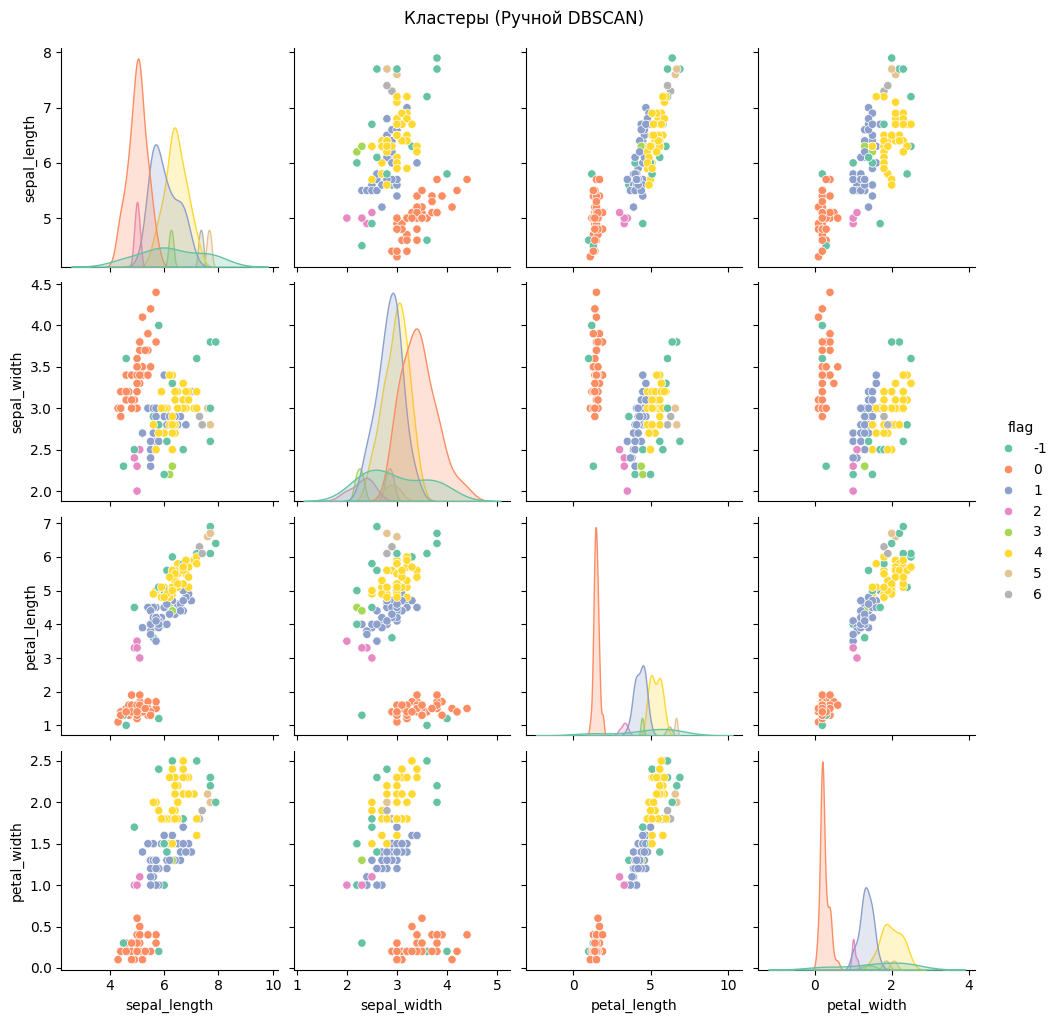

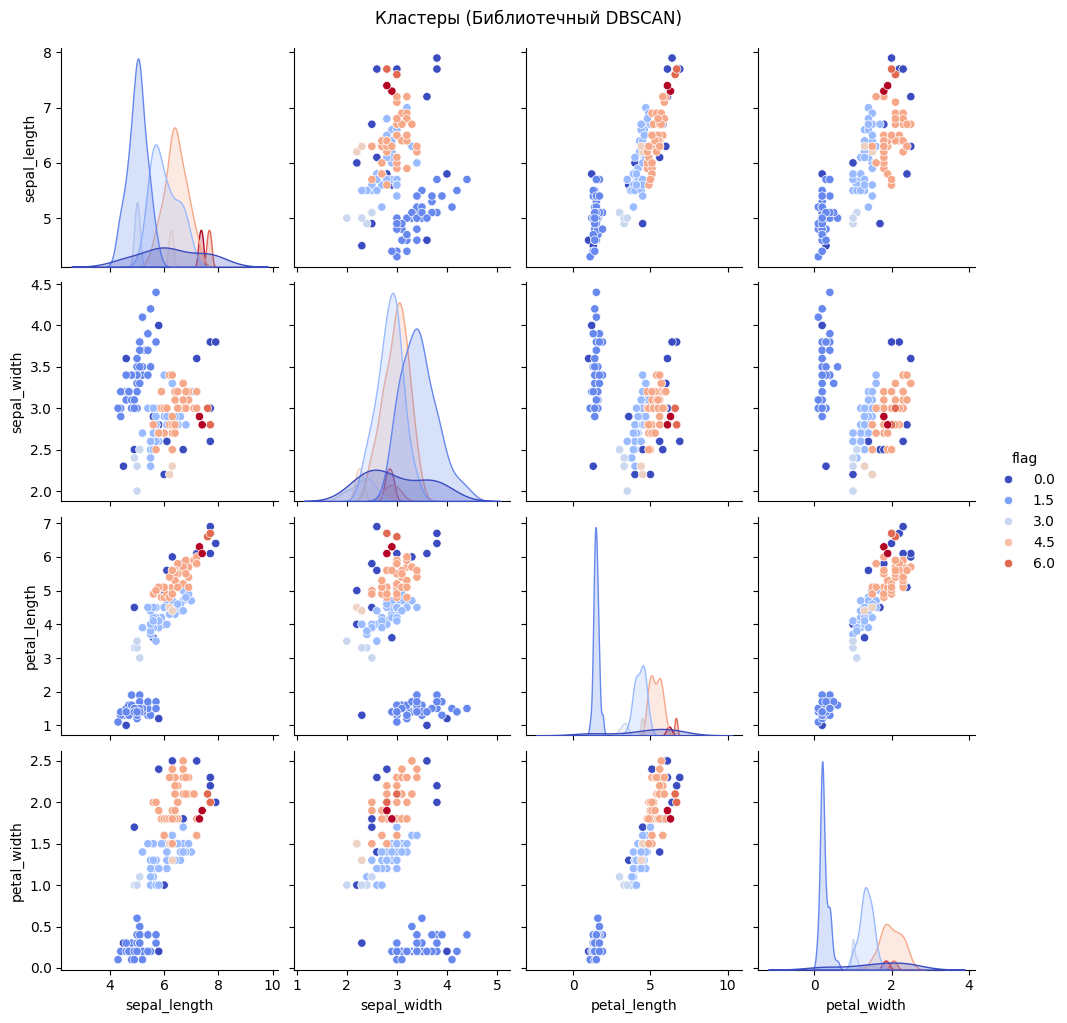

In [126]:
g1 = sns.pairplot(df_dbscan_iris_, hue='flag', palette='Set2')
g1.fig.suptitle('Кластеры (Ручной DBSCAN)', y=1.02)

g2 = sns.pairplot(df_dbscan_iris, hue='flag', palette='coolwarm')
g2.fig.suptitle('Кластеры (Библиотечный DBSCAN)', y=1.02)
